# Time series analysis for furniture sales

데이터 링크는 [Superstore sales data](https://community.tableau.com/docs/DOC-1236)입니다.

첫 번째 튜토리얼의 목적은 **<font color=red>시계열 데이터를 분석하여 furniture(가구)의 판매를 예측</font>**하는 것입니다.

In [134]:
import warnings
warnings.filterwarnings("ignore")

In [187]:
import itertools
import matplotlib as mpl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [136]:
import statsmodels.api as sm

In [190]:
plt.style.use('fivethirtyeight')

## 데이터 로딩

`pip install xlrd`

In [137]:
pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [138]:
df = pd.read_excel("./input/Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [139]:
df.shape

(9994, 21)

*Category*컬럼에서 값이 *Furniture*인 데이터를 불러옵니다.

In [140]:
furniture = df.loc[df.Category == 'Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


데이터의 시점과 종점을 살펴봅니다.

In [141]:
print('시점 :', furniture['Order Date'].min())
print('종점 :', furniture['Order Date'].max())

시점 : 2014-01-06 00:00:00
종점 : 2017-12-30 00:00:00


총 4년 동안의 데이터 입니다.

해당 컬럼의 데이터 타입을 살펴봅니다

In [142]:
type(furniture['Order Date'].min())

pandas._libs.tslib.Timestamp

## Data Preprocessing
- 사용하지 않을 컬럼을 제거하겠습니다.
- Missing value를 체크합니다.
- 컬럼을 aggregation합니다.
- 시계열 인덱싱으로 변환합니다.

### 1. 사용하지 않을 컬럼 제거
- 사용하는 컬럼은 시간 정보가 있는 *Order Date*와, 그 날의 판매량인 *Sales* 입니다.

In [143]:
columns = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
           'Customer ID', 'Customer Name', 'Segment', 'Country', 
           'City', 'State', 'Postal Code', 'Region', 
           'Product ID', 'Category', 'Sub-Category', 'Product Name', 
           'Quantity', 'Discount', 'Profit']

In [144]:
furniture.drop(columns, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [145]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


### 2. Missing value를 체크

In [146]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

### 3. 컬럼 aggregation

각 날짜별로 record의 수를 체크해봅니다.

In [147]:
furniture.groupby('Order Date').count().sort_values(by='Sales', ascending=False).head()

,Sales
Order Date,
2016-09-05,10
2016-12-25,9
2016-12-01,9
2017-11-19,9
2017-10-30,9


날짜별로 record의 수가 여러개 존재하는 경우가 있으므로, sales을 aggregation 합니다.

In [178]:
furniture = furniture.groupby('Order Date').agg({'Sales': 'sum'}).reset_index()
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


### 4. Indexing

In [179]:
furniture = furniture.set_index('Order Date', drop=True)
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

시계열 데이터는 다루기 힘든 경우가 많습니다. 미시적(micro)인 관점에서 살펴보아도 좋지만, 먼저 거시적(macro)인 단위에서의 경향성을 예측해보고, 범위를 좁혀가는 방법이 좋습니다.

따라서, 1일 판매량 단위로 끊어서보지 않고, 1달 판매량의 평균으로 살펴보도록 하겠습니다.

Pandas는 시계열 데이터를 다룰때, range를 다루기 쉬운 메소드를 제공해줍니다.

`resample` reference : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

In [181]:
x = furniture['Sales'].resample('MS').mean()
x.head(5)

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

In [186]:
x.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

## Visualization

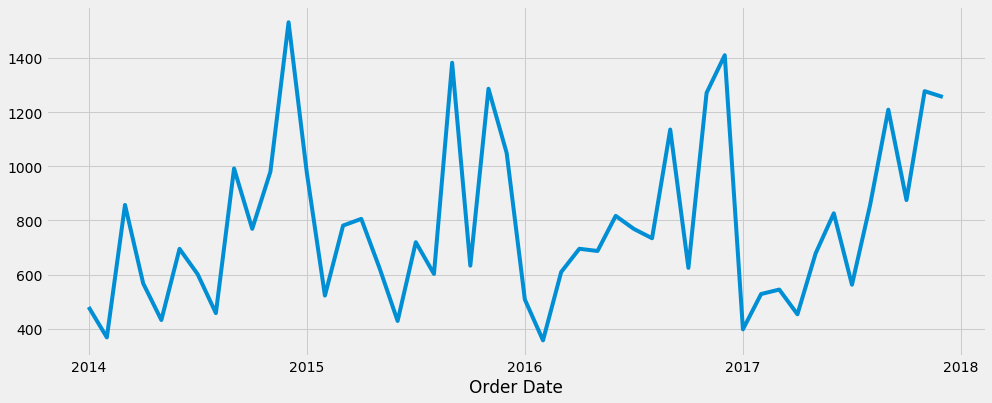

In [191]:
x.plot(figsize=(15, 6))

Time series decomposition
 - trend
 - seasonality
 - noise

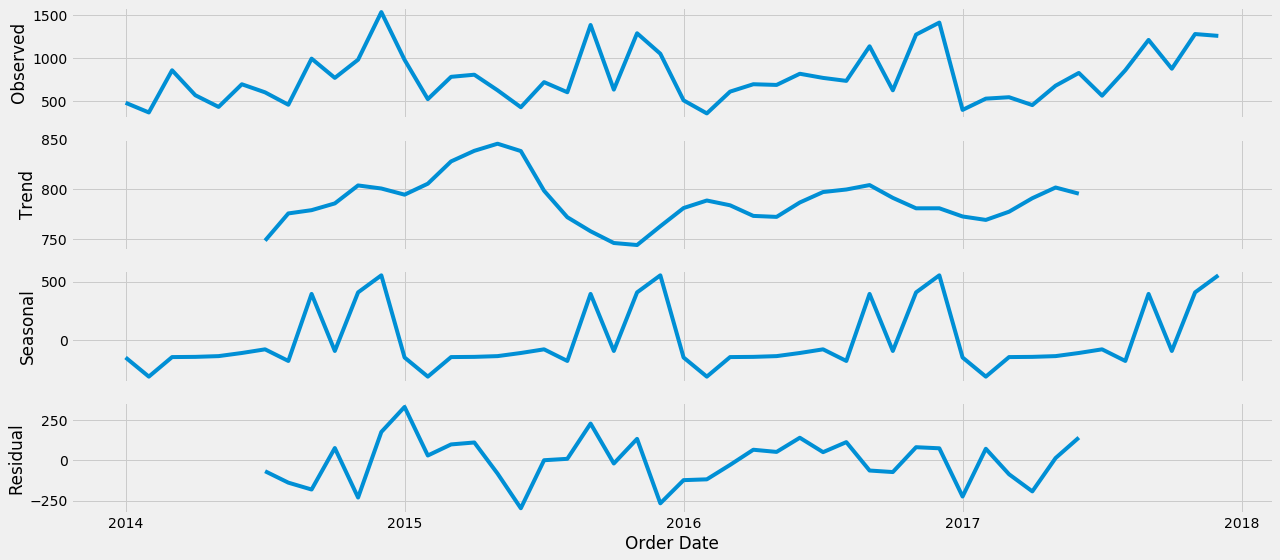

In [192]:
decomposition = sm.tsa.seasonal_decompose(x, model='additive')
mpl.rcParams['figure.figsize'] = (18, 8)
fig = decomposition.plot()

## Time series modeling with ARIMA

시계열 분석에 많이 사용하는 ARIMA를 사용하자.

(Autoregressive Integrated Moving Average)

In [193]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [194]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [195]:
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(p, d, q))]

In [196]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [197]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


- Parameter selection for our furniture’s sales ARIMA time series model
- Grid search

In [198]:
import traceback

In [199]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(x,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(missing = 'drop')
            print('ARIMA{}x{}12 - AIC:{}'
                  .format(param, param_seasonal, results.aic))
        except Exception:
#             print(results.mle_retvals)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1446.5593245884702
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1172.2086741447833
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2900.357535652858
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809126
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.580913309711
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.1394870316744
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.988487694687
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1250.256448915547
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1550.2028404680511
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(

최적의 parameter는 $(1,1,1)\times(1,1,0,12)$ 이다.

In [210]:
mod = sm.tsa.statespace.SARIMAX(x,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


Our model diagnostics suggests that the model residuals are near normally distributed.

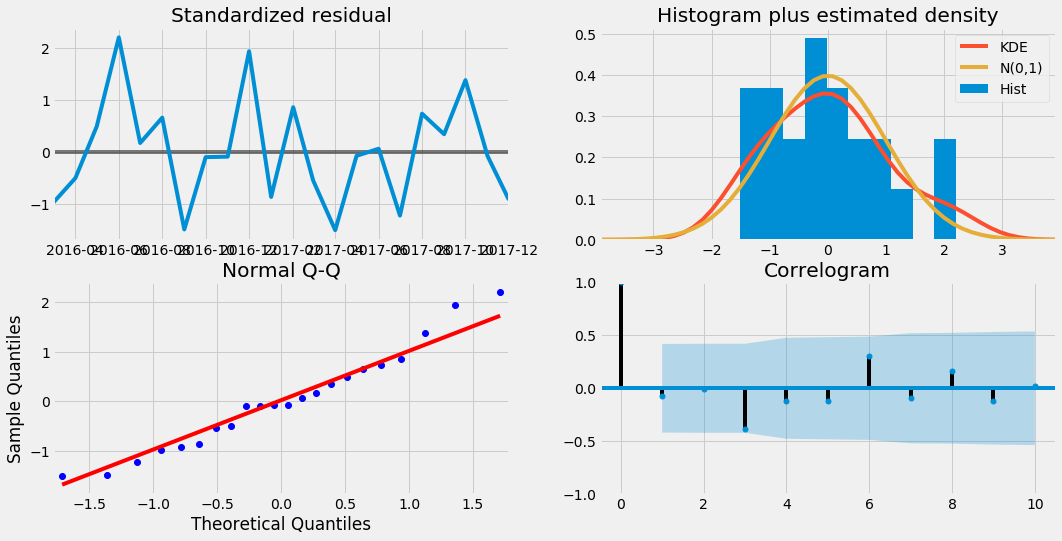

In [212]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

2017-01-01 부터의 실제 데이터와, 모델에 의하여 예측된 값을 비교해보도록 한다.

### 1. Test set을 이용하여 prediction

In [213]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

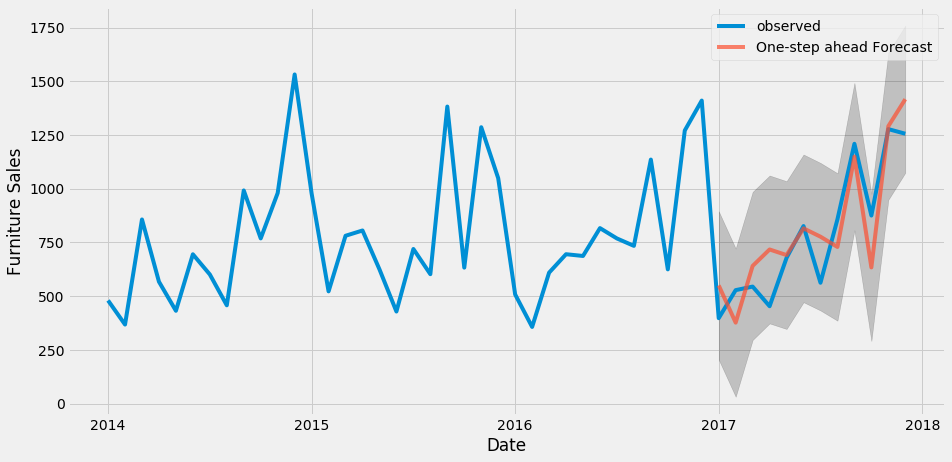

In [215]:
ax = x['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

예측모델을 살펴보면, 2017년의 시작에서부터 upward trend를 보여주고 있으며, 2017년의 마지막까지의 seasonality를 나쁘지 않게 잡아내고 있다.

### 2. Performance of the prediction

In [216]:
x_forecasted = pred.predicted_mean
x_truth = x['2017-01-01':]
mse = ((x_forecasted - x_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.58


In [217]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


RMSE의 결과는 우리의 모델이 일일 가구 판매량에 대하여, 실제 판매량과 비교하여 평균적으로 151.64의 차이 내외로 예측한다는 것을 말해준다.

## Produciong and visualizing forecasts

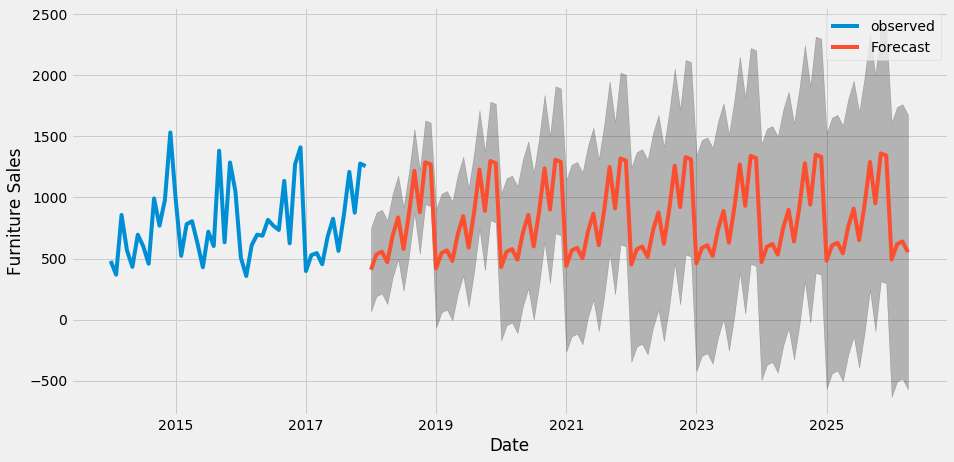

In [219]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = x.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

SARIMA 모델은 판매량의 seasonality를 잘 잡아내고 있다. 우리가 예측하려는 timeline이 현재에서부터 멀어질수록 우리가 예측하는 값에 대해서 신뢰도가 떨어지는 것은 자연스러운 일이다.

---


# Time series analysis for furniture sales vs. office supplies

Furniture와 office supplies에 대하여 비교하는 모델을 만들어보겠습니다.

## Data preprocessing

In [221]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

In [222]:
print(furniture.shape)
print(office.shape)

(2121, 21)
(6026, 21)


사용하지 않을 column들을 삭제합니다.

In [226]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 'Segment', 'Country', 
        'City', 'State', 'Postal Code', 'Region', 'Product ID', 
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 
        'Discount', 'Profit']

In [225]:
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

판매일자 순으로 정렬합니다.

In [227]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

판매량의 합을 구합니다.

In [237]:
furniture = furniture.groupby('Order Date') \
    .agg({'Sales': 'sum'}).reset_index()
office = office.groupby('Order Date') \
    .agg({'Sales': 'sum'}).reset_index()

Time index를 생성합니다.

In [238]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

월별 판매량으로 변경합니다.

In [239]:
x_furniture = furniture['Sales'].resample('MS').mean()
x_office = office['Sales'].resample('MS').mean()

In [240]:
furniture = pd.DataFrame(
    {'Order Date':x_furniture.index, 
     'furniture_sales':x_furniture.values}
)
office = pd.DataFrame(
    {'Order Date': x_office.index, 
     'office_sales': x_office.values}
)

두 개의 DataFrame을 merge 합니다.

In [241]:
store = furniture.merge(
    office, how='inner', on='Order Date'
)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


## Visualization

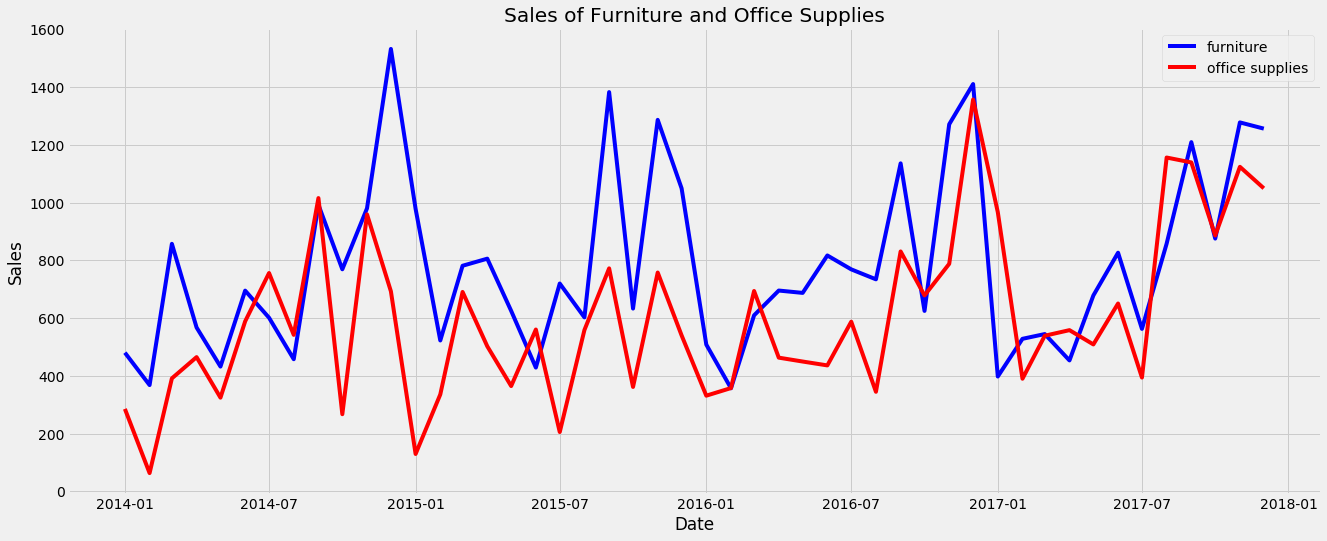

In [242]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Furniture and Office Supplies')
plt.legend()

데이터를 살펴보자.
 - Furniture와 office supplies는 비슷한 seasonal pattern을 공유한다.
 - 연초에는 sales가 두 개의 category 모두 낮다.
 - Furniture의 값이 대부분의 경우에서 office supplies보다 높다. 아주 드물게, office supplies가 높은 경우가 있다.

Office supplies sales가 furniture sales 보다 큰, 첫 번째 때가 언제일까?

In [244]:
first_date = \
    store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

In [245]:
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


## Time series analysis with Prophet

https://research.fb.com/prophet-forecasting-at-scale/

Prophet은 2017년 Facebook에서 발표한 시계열 데이터 분석 툴입니다. Prophet은 시계열 데이터를 분석하여 yearly, weekly, daily와 같은 서로 다른 time scale에 대하여 패턴을 발견하고 시각화해줍니다. 또한 holiday와 같이 time-series에 영향을 미치는 changepoints에 대한 모델링 기능도 제공해줍니다.

Anaconda를 이용하여 `fbprophet`를 import 합니다.

In [248]:
from fbprophet import Prophet

Furniture를 `Prophet`을 이용하여 학습합니다. Dataframe의 column은 `ds`, `y`를 갖도록 합니다.

In [252]:
furniture = \
    furniture.rename(columns={'Order Date': 'ds', 'furniture_sales': 'y'})

In [253]:
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Office supplies를 학습합니다.

In [254]:
office = office.rename(columns={'Order Date': 'ds', 'office_sales': 'y'})

In [255]:
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Furniture에 대한 forecast를 생성합니다.

In [256]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

Office supplies에 대한 forecast를 생성합니다.

In [257]:
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

Furniture의 결과를 시각화합니다.

Text(0.5,1,'Furniture Sales')

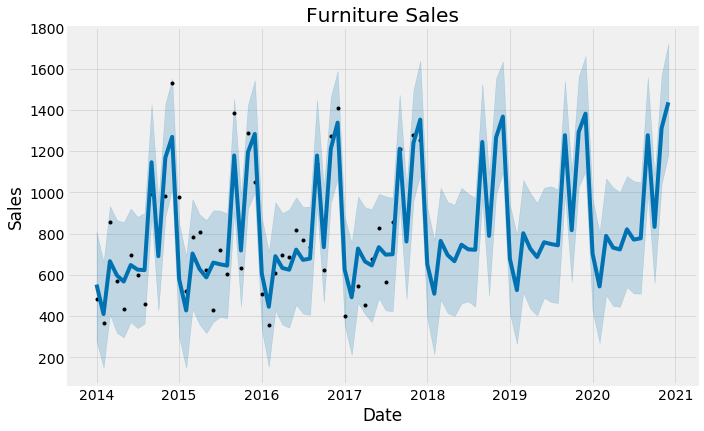

In [259]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')

Office supplies의 결과를 시각화합니다.

Text(0.5,1,'Office Supplies Sales')

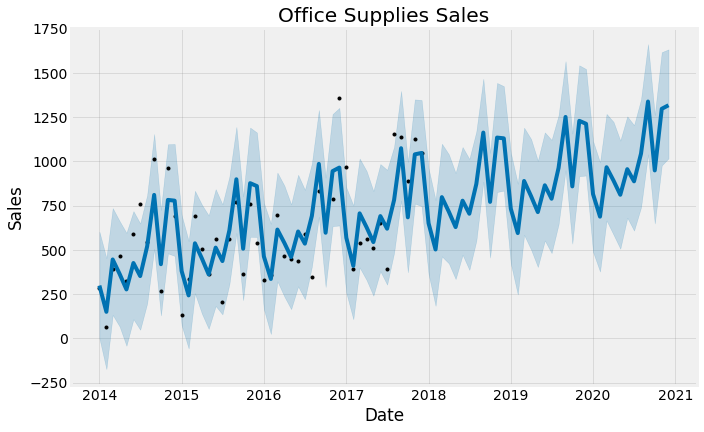

In [261]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales')

## Forecasts의 비교

2개 카테고리에 대하여, 3년치의 예측치를 구했습니다. 예측치를 join 하겠습니다.

In [263]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

In [264]:
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

In [265]:
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

In [266]:
forecast = pd.merge(
    merge_furniture_forecast, 
    merge_office_forecast, 
    how = 'inner', 
    left_on = 'furniture_ds', 
    right_on = 'office_ds'
)

In [267]:
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_trend_lower,furniture_trend_upper,furniture_yhat_lower,furniture_yhat_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_yhat,office_trend,office_trend_lower,office_trend_upper,office_yhat_lower,office_yhat_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_yhat
0,2014-01-01,731.350832,731.350832,731.350832,278.629547,808.564525,-178.935009,-178.935009,-178.935009,0.0,0.0,0.0,-178.935009,-178.935009,-178.935009,552.415823,430.348152,430.348152,430.348152,0.324657,602.163321,-132.487041,-132.487041,-132.487041,0.0,0.0,0.0,-132.487041,-132.487041,-132.487041,297.861111
1,2014-02-01,733.442293,733.442293,733.442293,149.541273,661.775952,-324.072006,-324.072006,-324.072006,0.0,0.0,0.0,-324.072006,-324.072006,-324.072006,409.370287,437.820220,437.820220,437.820220,-173.812350,452.956534,-288.224139,-288.224139,-288.224139,0.0,0.0,0.0,-288.224139,-288.224139,-288.224139,149.596082
2,2014-03-01,735.331355,735.331355,735.331355,408.578197,933.757998,-69.359319,-69.359319,-69.359319,0.0,0.0,0.0,-69.359319,-69.359319,-69.359319,665.972036,444.569186,444.569186,444.569186,132.145105,735.321878,0.847373,0.847373,0.847373,0.0,0.0,0.0,0.847373,0.847373,0.847373,445.416558
3,2014-04-01,737.422817,737.422817,737.422817,318.399824,865.574653,-140.383817,-140.383817,-140.383817,0.0,0.0,0.0,-140.383817,-140.383817,-140.383817,597.038999,452.041255,452.041255,452.041255,65.874560,661.408682,-89.140087,-89.140087,-89.140087,0.0,0.0,0.0,-89.140087,-89.140087,-89.140087,362.901168
4,2014-05-01,739.446812,739.446812,739.446812,296.079856,853.936742,-172.281896,-172.281896,-172.281896,0.0,0.0,0.0,-172.281896,-172.281896,-172.281896,567.164915,459.272290,459.272290,459.272290,-42.108713,595.527937,-183.186206,-183.186206,-183.186206,0.0,0.0,0.0,-183.186206,-183.186206,-183.186206,276.086083


시각화해보겠습니다.

Text(0.5,1,'Furniture vs. Office Supplies Sales Trend')

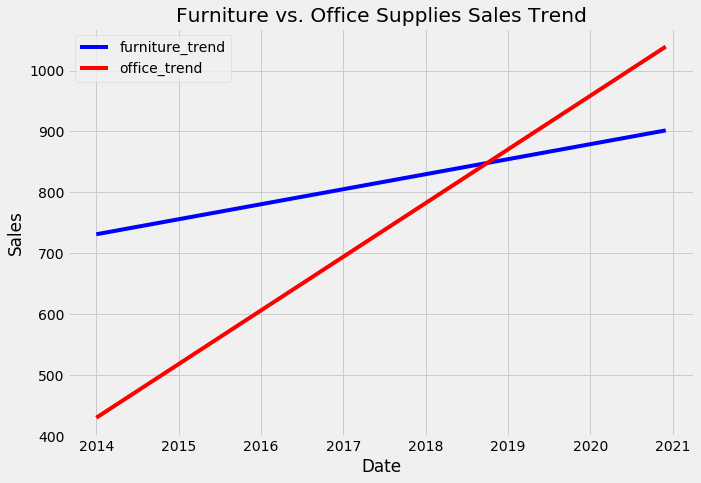

In [268]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend')

Text(0.5,1,'Furniture vs. Office Supplies Estimate')

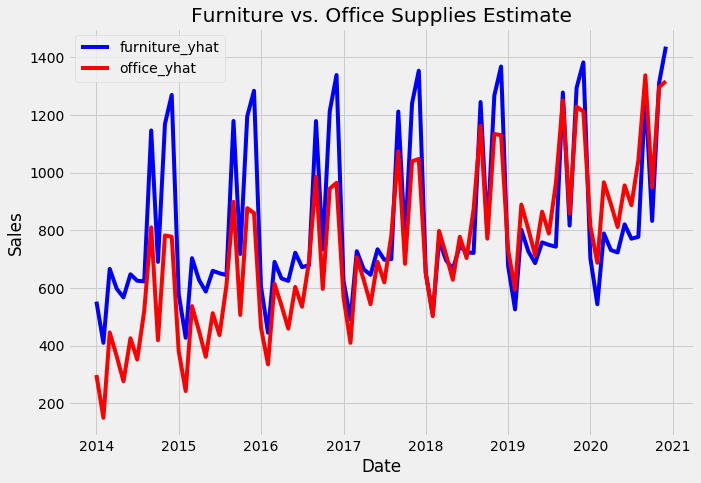

In [269]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate')

## Trends and Patterns

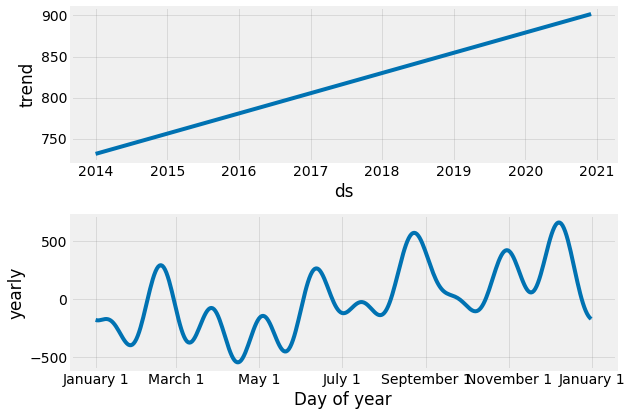

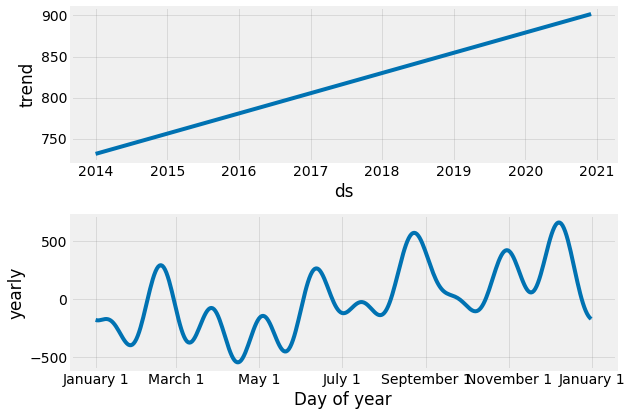

In [270]:
furniture_model.plot_components(furniture_forecast)

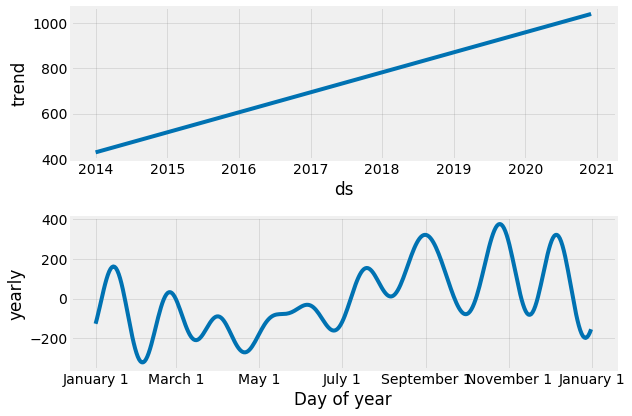

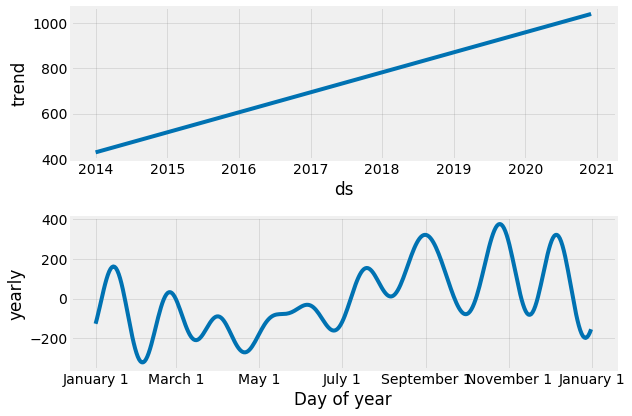

In [271]:
office_model.plot_components(office_forecast)

- Furniture와 office supplies 둘 다 시간이 흐를수록 선형적으로 증가하는 형태를 보인다. Office supplies의 성장세가 조금더 가파르다.
- Furniture의 sales가 가장 낮은 달은 April이다. Office supplies의 sales이 가장 낮은 달은 Fubruary이다. 
- Furniture의 sales가 가장 높은 달은 December이다. Office supplies의 sales이 가장 높은 달은 October이다. 

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3